In [1]:
!make docker-image > /dev/null 2>&1

In [2]:
!CONTAINER_CMD="bash -lc 'make install-ycsb'" make docker > /dev/null 2>&1

In [3]:
from pathlib import Path
import pexpect
import os
import time

""" Collector class has helper methods to interact with kermit"""
class Collector: 
    def __init__(self, config: Path):
        self.env = os.environ.copy()
        self.env["INTERACTIVE"] = "it"
        self.env["CONTAINER_CMD"] = f"bash -lc 'KERNMLOPS_CONFIG_FILE={config} make collect-data'"
        self.collect_process : pexpect.spawn | None = None

    def start_collection(self, logfile=None):
        self.collect_process = pexpect.spawn("make docker", env=self.env, timeout=None, logfile=logfile)
        self.collect_process.expect_exact(["Started benchmark"])

    def _after_run_generate_file_data() -> dict[str, list[Path]]:
        start_path : Path = Path("./data")
        list_of_collect_id_dirs = start_path.glob("*/*/*")
        latest_collect_id = max(list_of_collect_id_dirs, key=os.path.getctime)
        list_of_files = latest_collect_id.glob("*.*.parquet")
        output = {}
        for f in list_of_files:
            index = str(f).removeprefix(str(f.parent) + "/").split(".")[0]
            if index not in output.keys():
                output[index] = []
            output[index].append(f)
        return output
        
    def wait(self) -> int:
        if self.collect_process is None:
            return
        self.collect_process.expect([pexpect.EOF])
        self.collect_process.wait()
        return Collector._after_run_generate_file_data()
        
    def stop_collection(self):
        if self.collect_process is None:
            return
        self.collect_process.sendline("END")
        return self.wait()

In [4]:
import polars as pl

def filter_process_trace(process_trace_df: pl.DataFrame) -> pl.DataFrame :
    df = process_trace_df
    # Filter just the processes
    df = df.filter(pl.col("tgid") == pl.col("pid")).drop("collection_id")

    # Find the last name of each process
    start_df = df.sort(pl.col("ts_ns"), descending = True)
    helper_dict = {}
    for row in start_df.iter_rows():
        pid = row[0]
        comm = row[3]
        if pid in helper_dict.keys() or comm == "": 
            continue
        helper_dict[pid] = comm

    # Separate the start and end
    full_df = start_df.with_columns(pl.col("pid").map_elements(lambda x : helper_dict.get(x, ""), return_dtype=str).alias("full_name"))
    full_df = full_df.drop(["tgid", "name"])
    start_df = full_df.filter(pl.col("cap_type") == "start").rename({"ts_ns": "start_ns"}).drop("cap_type")
    end_df = full_df.filter(pl.col("cap_type") == "end").rename({"ts_ns": "end_ns"}).drop(["cap_type", "full_name"])

    # Join them to get the process table
    return start_df.join(end_df, "pid")



In [5]:
import polars as pl

def filter_process_trace(process_trace_df: pl.DataFrame) -> pl.DataFrame :
    df = process_trace_df
    # Filter just the processes
    df = df.filter(pl.col("tgid") == pl.col("pid")).drop("collection_id")

    # Find the last name of each process
    start_df = df.sort(pl.col("ts_ns"), descending = True)
    helper_dict = {}
    for row in start_df.iter_rows():
        pid = row[0]
        comm = row[3]
        if pid in helper_dict.keys() or comm == "": 
            continue
        helper_dict[pid] = comm

    # Separate the start and end
    full_df = start_df.with_columns(pl.col("pid").map_elements(lambda x : helper_dict.get(x, ""), return_dtype=str).alias("full_name"))
    full_df = full_df.drop(["tgid", "name"])
    start_df = full_df.filter(pl.col("cap_type") == "start").rename({"ts_ns": "start_ns"}).drop("cap_type")
    end_df = full_df.filter(pl.col("cap_type") == "end").rename({"ts_ns": "end_ns"}).drop(["cap_type", "full_name"])

    # Join them to get the process table
    combined_df = start_df.join(end_df, "pid")
    return combined_df.with_columns((pl.col("end_ns") - pl.col("start_ns")).alias("duration"))

def process_trace_start_end_ts(process_trace_df: pl.DataFrame, proc_name: str, index: int) ->(int, int, int):
    trace_df = filter_process_trace(process_trace_df).sort(pl.col("start_ns"))
    df = trace_df.filter(pl.col("full_name") == proc_name)
    print(df)
    df = df[index]
    pid = df["pid"][0]
    start_ns = df["start_ns"][0]
    end_ns = df["end_ns"][0]
    return pid, start_ns, end_ns

def clean_rss_pid(rss_df: pl.DataFrame, pid: int) -> pl.DataFrame:
    df = rss_df.drop(["pid", "collection_id"]).sort(pl.col("ts_ns"))
    df = df.filter(pl.col("tgid") == pid)
    df = df.with_columns(pl.when(pl.col("member") == "MM_FILEPAGES")
                     .then(pl.col("count"))
                     .otherwise(None)
                     .fill_null(strategy="forward")
                     .fill_null(strategy="backward")
                     .alias("file"))
    df = df.with_columns(pl.when(pl.col("member") == "MM_ANONPAGES")
                     .then(pl.col("count"))
                     .otherwise(None)
                     .fill_null(strategy="forward")
                     .fill_null(strategy="backward")
                     .alias("anon"))
    df = df.with_columns(pl.when(pl.col("member") == "MM_SWAPENTS")
                     .then(pl.col("count"))
                     .otherwise(None)
                     .fill_null(strategy="forward")
                     .fill_null(strategy="backward")
                     .alias("swap"))
    df = df.drop(["member", "count"])
    zero_df = pl.DataFrame({"tgid": pid, "ts_ns" : -1, "file" : 0, "anon": 0, "swap": 0})
    df = pl.concat([df, zero_df]).sort("ts_ns")
    df = df.fill_null(strategy="forward")
    df = df.filter(pl.col("ts_ns") >= 0)
    df = df.with_columns((pl.col("file") + pl.col("anon") + pl.col("swap")).alias("count"))
    df = df.drop(["file", "anon", "swap"])
    return df

def filter_rss_with_ts(rss_trace_df: pl.DataFrame, start: int, end: int):
    print(start, end)
    new_frame_dict = {}
    for column_name in rss_trace_df.columns:
        new_frame_dict[column_name] = [None, None]
    new_frame_dict["ts_ns"] = [start, end]
    df = rss_trace_df.vstack(pl.DataFrame(new_frame_dict))
    df = df.sort(pl.col("ts_ns")).fill_null(strategy="forward").fill_null(strategy="backward")
    return df.filter(pl.col("ts_ns").is_between(start, end, closed='both'))

def get_proper_rss(proc_path: Path, rss_path: Path, rss_name: str, rss_ind: int, runner_name: str, runner_ind: int, tag:str):
    proc_trace_df = pl.read_parquet(proc_path)
    rss_df = pl.read_parquet(rss_path)

    _, start, end = process_trace_start_end_ts(proc_trace_df, runner_name, runner_ind)
    pid, _, _ = process_trace_start_end_ts(proc_trace_df, rss_name, rss_ind)
    clean_rss_df = filter_rss_with_ts(clean_rss_pid(rss_df, pid), start, end)
    return clean_rss_df.with_columns((pl.col("ts_ns") - pl.min("ts_ns")).alias("norm_ts_ns")).with_columns(pl.lit(tag).alias('policy'))

from pathlib import Path
from plotnine import ggplot, aes, geom_line, geom_point, labs

def create_graph(inputs: [(str, dict[str, Path])], proc_tag: str, proc_ind: int, time_proc_tag: str, time_proc_index: int, title: str) -> None:
    df = pl.DataFrame()
    for (tag, filedict) in inputs:
        append_df = get_proper_rss(filedict["process_trace"],
                                   filedict["mm_rss_stat"],
                                   proc_tag, proc_ind,
                                   time_proc_tag,
                                   time_proc_index,
                                   tag).drop(["tgid", "ts_ns"])
        df = pl.concat([df, append_df])
    df = df.with_columns((pl.col("norm_ts_ns") / (10**9)/ 60).alias("norm_ts_mins"))
    plt0 = (ggplot(df)
            + aes("norm_ts_mins", y="count", colour="policy")
            + geom_point()
            + geom_line()
            + labs(x="Time (mins)",
                   y="4kB Pages",
                   title=title)
           )
    return plt0

In [6]:
collect = Collector("./config/redis_never.yaml")
collect.start_collection(None)
redis_never_info = collect.wait()
collect = Collector("./config/redis_madvise.yaml")
collect.start_collection(None)
redis_madvise_info = collect.wait()
collect = Collector("./config/redis_always.yaml")
collect.start_collection(None)
redis_always_info = collect.wait()

In [7]:
collect = Collector("./config/fio.yaml")
collect.start_collection(None)
fio_info = collect.wait()

In [8]:
#collect = Collector("./config/postgresql.yaml")
#collect.start_collection(None)
#fio_info = collect.wait()

In [9]:
import polars as pl
vfs_df = pl.read_parquet(redis_always_info["vfs_read"][0])
vfs_df_fio = pl.read_parquet(fio_info["vfs_read"][0])
vfs_write_df = pl.read_parquet(redis_always_info["vfs_write"][0])
vfs_write_df_fio = pl.read_parquet(fio_info["vfs_write"][0]) 

In [10]:
print(vfs_df.columns)
print(vfs_df_fio.columns)
print(vfs_write_df.columns)
print(vfs_write_df_fio.columns)

['pid', 'tgid', 'comm', 'count', 'buf', 'ret', 'has_read', 'has_read_iter', 'which_read', 'success', 'ts_ns', 'collection_id']
['pid', 'tgid', 'comm', 'count', 'buf', 'ret', 'has_read', 'has_read_iter', 'which_read', 'success', 'ts_ns', 'collection_id']
['pid', 'tgid', 'comm', 'count', 'buf', 'ret', 'has_write', 'has_write_iter', 'which_write', 'success', 'ts_ns', 'collection_id']
['pid', 'tgid', 'comm', 'count', 'buf', 'ret', 'has_write', 'has_write_iter', 'which_write', 'success', 'ts_ns', 'collection_id']


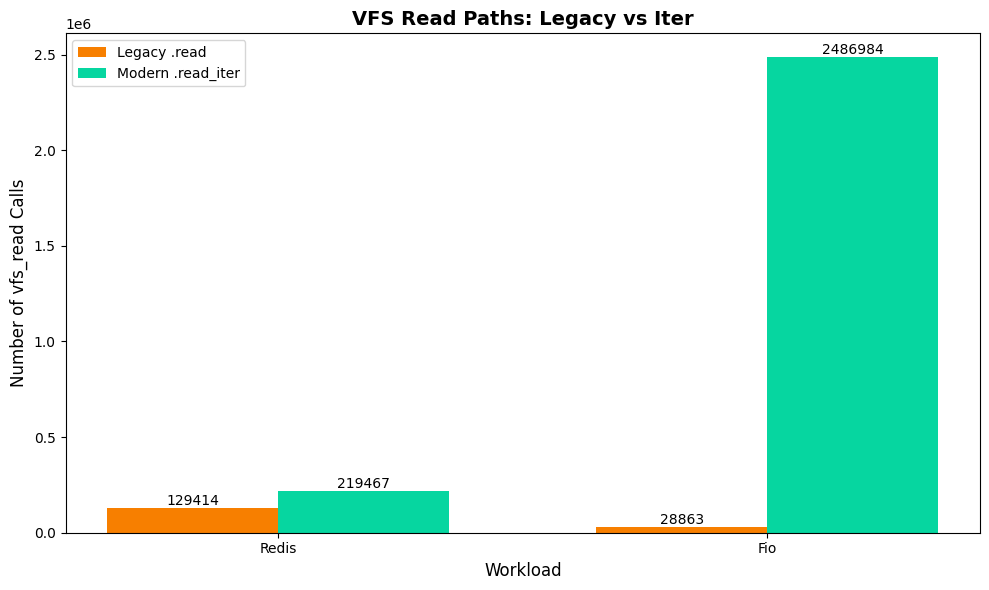

VFS READ PATH BREAKDOWN:
Redis: 37.1% legacy, 62.9% iter
Fio: 1.1% legacy, 98.9% iter


In [11]:
# =============================================================================
# CELL 1: VFS READS - Legacy vs Iter Paths  
# =============================================================================
import polars as pl
import matplotlib.pyplot as plt
import pandas as pd

# Load read data
vfs_read_df = pl.read_parquet(redis_always_info["vfs_read"][0])
vfs_read_df_fio = pl.read_parquet(fio_info["vfs_read"][0])

# Add workload labels and combine
vfs_read_df = vfs_read_df.with_columns(pl.lit("Redis").alias("workload"))
vfs_read_df_fio = vfs_read_df_fio.with_columns(pl.lit("Fio").alias("workload"))
reads_df = pl.concat([vfs_read_df, vfs_read_df_fio]).to_pandas()

# Count legacy vs iter for reads
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

workloads = ['Redis', 'Fio']
legacy_counts = []
iter_counts = []

for workload in workloads:
    workload_data = reads_df[reads_df['workload'] == workload]
    legacy_count = len(workload_data[workload_data['which_read'] == 1])  # 1 = legacy
    iter_count = len(workload_data[workload_data['which_read'] == 2])    # 2 = iter
    legacy_counts.append(legacy_count)
    iter_counts.append(iter_count)

x = range(len(workloads))
width = 0.35

bars1 = ax.bar([i - width/2 for i in x], legacy_counts, width, label='Legacy .read', color='#F77F00')
bars2 = ax.bar([i + width/2 for i in x], iter_counts, width, label='Modern .read_iter', color='#06D6A0')

ax.set_title('VFS Read Paths: Legacy vs Iter', fontsize=14, fontweight='bold')
ax.set_xlabel('Workload', fontsize=12)
ax.set_ylabel('Number of vfs_read Calls', fontsize=12)
ax.legend()
ax.set_xticks(x)
ax.set_xticklabels(workloads)
ax.bar_label(bars1, fmt='%d')
ax.bar_label(bars2, fmt='%d')

plt.tight_layout()
out_path = "vfs_read_paths_redis_fio.png"   # name it whatever you like
plt.savefig(out_path, dpi=300, bbox_inches='tight')  # high‑res PNG for print
plt.show()

print("VFS READ PATH BREAKDOWN:")
for i, workload in enumerate(workloads):
    total = legacy_counts[i] + iter_counts[i]
    if total > 0:
        legacy_pct = legacy_counts[i] / total * 100
        iter_pct = iter_counts[i] / total * 100
        print(f"{workload}: {legacy_pct:.1f}% legacy, {iter_pct:.1f}% iter")
    else:
        print(f"{workload}: No read data")

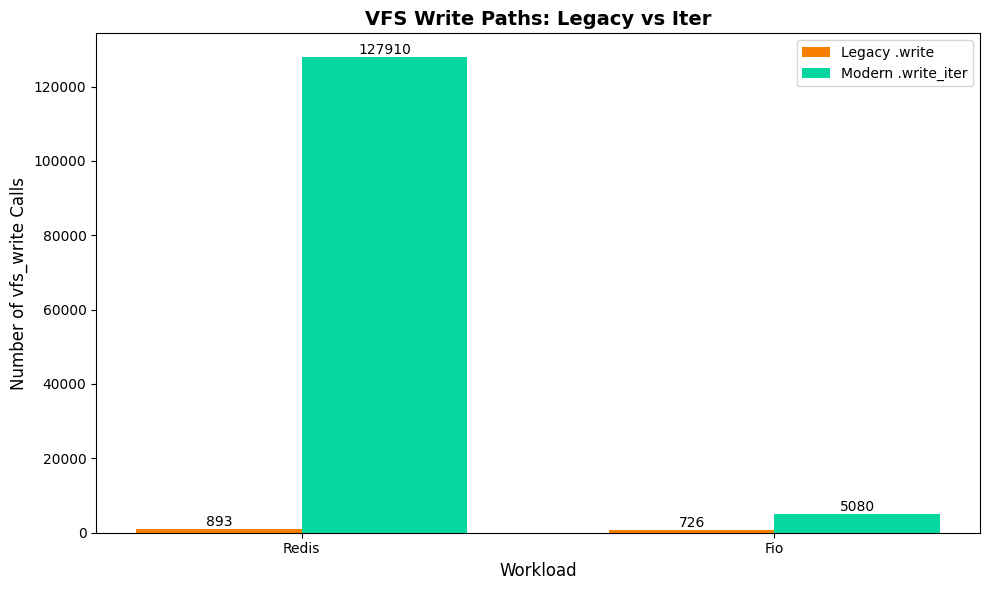

VFS WRITE PATH BREAKDOWN:
Redis: 0.7% legacy, 99.3% iter
Fio: 12.5% legacy, 87.5% iter


In [12]:
# =============================================================================
# CELL 2: VFS WRITES - Legacy vs Iter Paths
# =============================================================================
import polars as pl
import matplotlib.pyplot as plt
import pandas as pd

# Load write data
vfs_write_df = pl.read_parquet(redis_always_info["vfs_write"][0])
vfs_write_df_fio = pl.read_parquet(fio_info["vfs_write"][0])

# Add workload labels and combine
vfs_write_df = vfs_write_df.with_columns(pl.lit("Redis").alias("workload"))
vfs_write_df_fio = vfs_write_df_fio.with_columns(pl.lit("Fio").alias("workload"))
writes_df = pl.concat([vfs_write_df, vfs_write_df_fio]).to_pandas()

# Count legacy vs iter for writes
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

workloads = ['Redis', 'Fio']
legacy_counts = []
iter_counts = []

for workload in workloads:
    workload_data = writes_df[writes_df['workload'] == workload]
    legacy_count = len(workload_data[workload_data['which_write'] == 1])  # 1 = legacy
    iter_count = len(workload_data[workload_data['which_write'] == 2])    # 2 = iter
    legacy_counts.append(legacy_count)
    iter_counts.append(iter_count)

x = range(len(workloads))
width = 0.35

bars1 = ax.bar([i - width/2 for i in x], legacy_counts, width, label='Legacy .write', color='#F77F00')
bars2 = ax.bar([i + width/2 for i in x], iter_counts, width, label='Modern .write_iter', color='#06D6A0')

ax.set_title('VFS Write Paths: Legacy vs Iter', fontsize=14, fontweight='bold')
ax.set_xlabel('Workload', fontsize=12)
ax.set_ylabel('Number of vfs_write Calls', fontsize=12)
ax.legend()
ax.set_xticks(x)
ax.set_xticklabels(workloads)
ax.bar_label(bars1, fmt='%d')
ax.bar_label(bars2, fmt='%d')

plt.tight_layout()
plt.savefig("vfs_write_paths_redis_fio.png", dpi=300, bbox_inches='tight')
plt.savefig("vfs_write_paths_redis_fio.pdf", bbox_inches='tight')
plt.show()

print("VFS WRITE PATH BREAKDOWN:")
for i, workload in enumerate(workloads):
    total = legacy_counts[i] + iter_counts[i]
    if total > 0:
        legacy_pct = legacy_counts[i] / total * 100
        iter_pct = iter_counts[i] / total * 100
        print(f"{workload}: {legacy_pct:.1f}% legacy, {iter_pct:.1f}% iter")
    else:
        print(f"{workload}: No write data")

In [13]:
# Debug the which_read values
print("Debugging which_read values:")
print("Redis reads - which_read unique values:", reads_df[reads_df['workload'] == 'Redis']['which_read'].unique())
print("Fio reads - which_read unique values:", reads_df[reads_df['workload'] == 'Fio']['which_read'].unique())

# Check if there are any legacy reads for Fio
fio_reads = reads_df[reads_df['workload'] == 'Fio']
print(f"Fio total reads: {len(fio_reads)}")
print(f"Fio which_read == 0 (legacy): {len(fio_reads[fio_reads['which_read'] == 0])}")
print(f"Fio which_read == 1 (iter): {len(fio_reads[fio_reads['which_read'] == 1])}")
print(f"Fio other which_read values: {len(fio_reads[~fio_reads['which_read'].isin([0, 1])])}")

# Look at first few rows
print("\nFirst 5 Fio read entries:")
print(fio_reads[['which_read', 'has_read', 'has_read_iter']].head())

Debugging which_read values:
Redis reads - which_read unique values: [2 1]
Fio reads - which_read unique values: [2 1]
Fio total reads: 2515847
Fio which_read == 0 (legacy): 0
Fio which_read == 1 (iter): 28863
Fio other which_read values: 2486984

First 5 Fio read entries:
        which_read  has_read  has_read_iter
348881           2         0              1
348882           2         0              1
348883           2         0              1
348884           2         0              1
348885           2         0              1


/tmp/ipykernel_65290/2430586349.py:56: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.


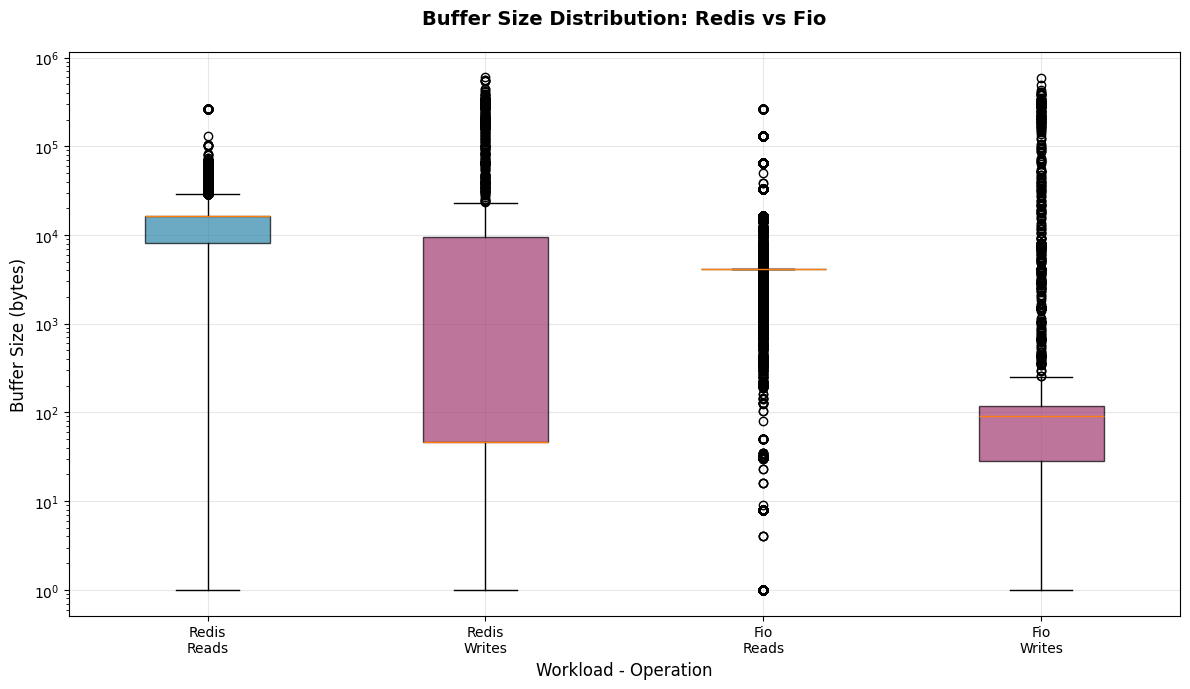

Buffer Size Summary Statistics:

Redis
Reads:
  Count: 348,881
  Mean: 12268.5 bytes
  Median: 16384.0 bytes
  Min: 1 bytes
  Max: 262,144 bytes
  25th percentile: 8192.0 bytes
  75th percentile: 16384.0 bytes

Redis
Writes:
  Count: 128,803
  Mean: 3718.9 bytes
  Median: 47.0 bytes
  Min: 1 bytes
  Max: 596,650 bytes
  25th percentile: 47.0 bytes
  75th percentile: 9368.0 bytes

Fio
Reads:
  Count: 2,515,847
  Mean: 4278.0 bytes
  Median: 4096.0 bytes
  Min: 1 bytes
  Max: 262,144 bytes
  25th percentile: 4096.0 bytes
  75th percentile: 4096.0 bytes

Fio
Writes:
  Count: 5,806
  Mean: 6146.1 bytes
  Median: 92.0 bytes
  Min: 1 bytes
  Max: 581,111 bytes
  25th percentile: 28.0 bytes
  75th percentile: 117.0 bytes


In [14]:
# =============================================================================
# CELL 3: BUFFER SIZE BOX PLOTS
# =============================================================================
import matplotlib.pyplot as plt
import numpy as np

# Load and combine data (reusing from previous cells)
vfs_read_df = pl.read_parquet(redis_always_info["vfs_read"][0])
vfs_read_df_fio = pl.read_parquet(fio_info["vfs_read"][0])
vfs_write_df = pl.read_parquet(redis_always_info["vfs_write"][0])
vfs_write_df_fio = pl.read_parquet(fio_info["vfs_write"][0])

# Add labels and combine
vfs_read_df = vfs_read_df.with_columns(pl.lit("Redis").alias("workload"), pl.lit("read").alias("operation"))
vfs_read_df_fio = vfs_read_df_fio.with_columns(pl.lit("Fio").alias("workload"), pl.lit("read").alias("operation"))
vfs_write_df = vfs_write_df.with_columns(pl.lit("Redis").alias("workload"), pl.lit("write").alias("operation"))
vfs_write_df_fio = vfs_write_df_fio.with_columns(pl.lit("Fio").alias("workload"), pl.lit("write").alias("operation"))

# Stack by operation type (same schema)
reads_combined = pl.concat([vfs_read_df, vfs_read_df_fio]).to_pandas()
writes_combined = pl.concat([vfs_write_df, vfs_write_df_fio]).to_pandas()

# Filter out zero and negative buffer sizes
reads_filtered = reads_combined[reads_combined['count'] > 0]
writes_filtered = writes_combined[writes_combined['count'] > 0]

# Create box plots
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

# Prepare data for box plots
box_data = []
labels = []
colors = ['#2E86AB', '#A23B72', '#2E86AB', '#A23B72']

# Redis reads
redis_reads = reads_filtered[reads_filtered['workload'] == 'Redis']['count'].values
box_data.append(redis_reads)
labels.append('Redis\nReads')

# Redis writes  
redis_writes = writes_filtered[writes_filtered['workload'] == 'Redis']['count'].values
box_data.append(redis_writes)
labels.append('Redis\nWrites')

# Fio reads
fio_reads = reads_filtered[reads_filtered['workload'] == 'Fio']['count'].values
box_data.append(fio_reads)
labels.append('Fio\nReads')

# Fio writes
fio_writes = writes_filtered[writes_filtered['workload'] == 'Fio']['count'].values
box_data.append(fio_writes)
labels.append('Fio\nWrites')

# Create box plot
bp = ax.boxplot(box_data, labels=labels, patch_artist=True)

# Color the boxes
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax.set_title('Buffer Size Distribution: Redis vs Fio', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Workload - Operation', fontsize=12)
ax.set_ylabel('Buffer Size (bytes)', fontsize=12)
ax.set_yscale('log')  # Log scale for wide range
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("buffer_size_distribution.png", dpi=300, bbox_inches='tight')
plt.savefig("buffer_size_distribution.pdf", bbox_inches='tight')  # optional vector format
plt.show()

# Print summary statistics
print("Buffer Size Summary Statistics:")
print("=" * 60)

for data, label in zip(box_data, labels):
    if len(data) > 0:
        print(f"\n{label}:")
        print(f"  Count: {len(data):,}")
        print(f"  Mean: {np.mean(data):.1f} bytes")
        print(f"  Median: {np.median(data):.1f} bytes") 
        print(f"  Min: {np.min(data)} bytes")
        print(f"  Max: {np.max(data):,} bytes")
        print(f"  25th percentile: {np.percentile(data, 25):.1f} bytes")
        print(f"  75th percentile: {np.percentile(data, 75):.1f} bytes")
    else:
        print(f"\n{label}: No data")

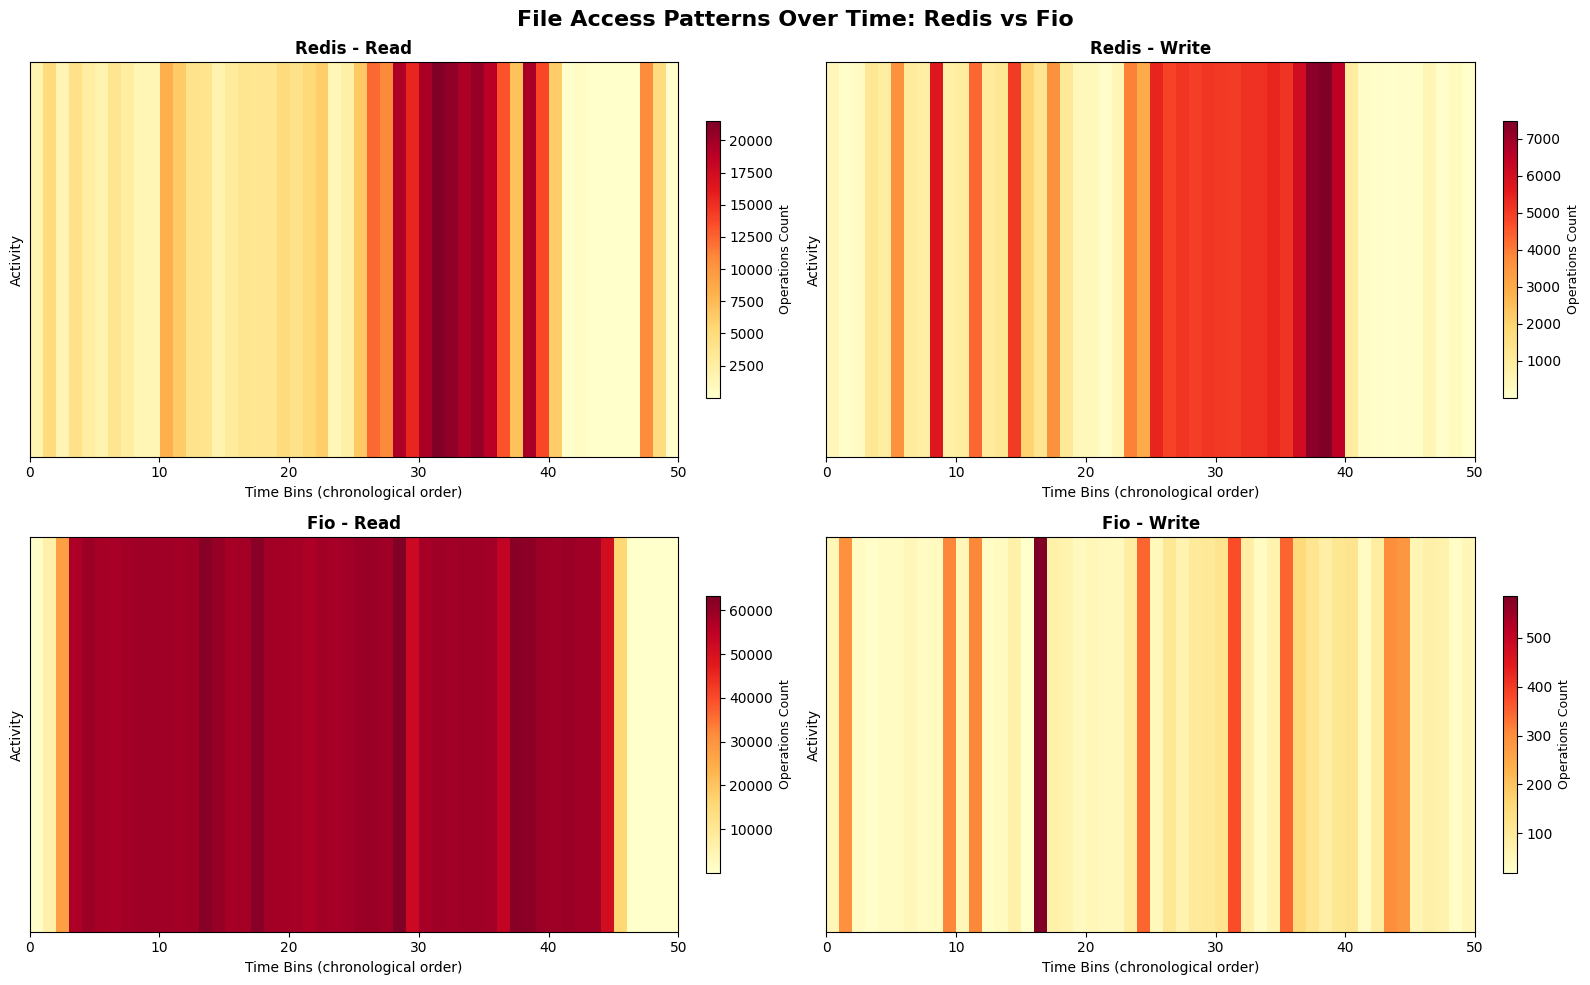


Timing Analysis:
Redis read: 348,881 ops over 88.2s (3954.0 ops/sec)
Redis write: 128,803 ops over 87.9s (1464.6 ops/sec)
Fio read: 2,515,847 ops over 70.2s (35849.6 ops/sec)
Fio write: 5,806 ops over 67.3s (86.3 ops/sec)


In [15]:
# =============================================================================
# CELL 4: ACCESS PATTERN HEATMAP OVER TIME (Fixed)
# =============================================================================
import matplotlib.pyplot as plt
import numpy as np

# Load and prepare data
vfs_read_df = pl.read_parquet(redis_always_info["vfs_read"][0])
vfs_read_df_fio = pl.read_parquet(fio_info["vfs_read"][0])
vfs_write_df = pl.read_parquet(redis_always_info["vfs_write"][0])
vfs_write_df_fio = pl.read_parquet(fio_info["vfs_write"][0])

# Add labels and select common columns
common_cols = ['pid', 'tgid', 'comm', 'count', 'buf', 'ret', 'success', 'ts_ns', 'collection_id']

vfs_read_df = vfs_read_df.select(common_cols).with_columns(pl.lit("Redis").alias("workload"), pl.lit("read").alias("operation"))
vfs_read_df_fio = vfs_read_df_fio.select(common_cols).with_columns(pl.lit("Fio").alias("workload"), pl.lit("read").alias("operation"))
vfs_write_df = vfs_write_df.select(common_cols).with_columns(pl.lit("Redis").alias("workload"), pl.lit("write").alias("operation"))
vfs_write_df_fio = vfs_write_df_fio.select(common_cols).with_columns(pl.lit("Fio").alias("workload"), pl.lit("write").alias("operation"))

# Combine all data
combined_df = pl.concat([vfs_read_df, vfs_read_df_fio, vfs_write_df, vfs_write_df_fio])
combined_pd = combined_df.to_pandas()

# Create 2x2 heatmap grid
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

workloads = ['Redis', 'Fio']
operations = ['read', 'write']

for i, (workload, operation) in enumerate([(w, o) for w in workloads for o in operations]):
    # Filter data for this workload and operation
    subset = combined_pd[(combined_pd['workload'] == workload) & 
                        (combined_pd['operation'] == operation)]
    
    if len(subset) == 0:
        axes[i].text(0.5, 0.5, f'No {operation} data\nfor {workload}', 
                    ha='center', va='center', transform=axes[i].transAxes, fontsize=12)
        axes[i].set_title(f'{workload} - {operation.capitalize()}', fontsize=12, fontweight='bold')
        continue
    
    # Create time bins using the timestamp
    time_data = subset['ts_ns'].values
    time_min, time_max = time_data.min(), time_data.max()
    
    # Create 50 time bins
    bins = np.linspace(time_min, time_max, 51)
    time_counts, _ = np.histogram(time_data, bins=bins)
    
    # Create heatmap data (1 row, many columns)
    heatmap_data = time_counts.reshape(1, -1)
    
    # Plot heatmap
    im = axes[i].imshow(heatmap_data, aspect='auto', cmap='YlOrRd', 
                       extent=[0, len(time_counts), 0, 1])
    axes[i].set_title(f'{workload} - {operation.capitalize()}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Time Bins (chronological order)', fontsize=10)
    axes[i].set_ylabel('Activity', fontsize=10)
    axes[i].set_yticks([])
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=axes[i], fraction=0.02, pad=0.04)
    cbar.set_label('Operations Count', fontsize=9)

plt.suptitle('File Access Patterns Over Time: Redis vs Fio', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Print timing statistics
print("\nTiming Analysis:")
print("=" * 50)
for workload in ['Redis', 'Fio']:
    for operation in ['read', 'write']:
        subset = combined_pd[(combined_pd['workload'] == workload) & 
                           (combined_pd['operation'] == operation)]
        if len(subset) > 0:
            duration = (subset['ts_ns'].max() - subset['ts_ns'].min()) / 1e9  # Convert to seconds
            rate = len(subset) / duration if duration > 0 else 0
            print(f"{workload} {operation}: {len(subset):,} ops over {duration:.1f}s ({rate:.1f} ops/sec)")
        else:
            print(f"{workload} {operation}: No data")

In [16]:
from plotnine import ggplot, aes, geom_point, geom_line, geom_hline, geom_text, labs, theme_set, theme, element_text, scale_y_continuous
from plotnine.themes import theme_bw

def plot_vfs_read_over_time(df: pl.DataFrame, title="vfs_read: Read Size Over Time"):
    if "ts_ns" not in df.columns:
        raise ValueError("ts_ns column is missing. Make sure it's included in the BPF event struct and data hook.")

    df = df.with_columns([
        pl.col("ts_ns").min().alias("norm_ts_ns_base"),
    ])
    df = df.with_columns([
        (pl.col("ts_ns") - pl.col("norm_ts_ns_base")).alias("norm_ts_ns"),
        ((pl.col("ts_ns") - pl.col("norm_ts_ns_base")) / 1e9 / 60).alias("norm_ts_mins"),
        pl.col("which_read").cast(str)
    ])

    #Use this line to filter out certain which_read values to get a better look at one in particular
    df = df.filter(pl.col("which_read") == "2")
    
    df_pd = df.to_pandas()

    SYSCALL_LABELS = {"0": "Unknown", "1": ".read", "2": ".read_iter"}
    df_pd["Syscall"] = df_pd["which_read"].map(SYSCALL_LABELS)

    # Set wider figure
    theme_set(
        theme_bw()
        + theme(
            figure_size=(12, 9),
            axis_text_x=element_text(rotation=45, ha='right'),
            #axis_text_y=element_text(size=7)
        )
    )
    
    return (
        ggplot(df_pd)
        + aes(x="norm_ts_mins", y="count", color="Syscall")
        + geom_point()
        + geom_line()
        #+ geom_hline(yintercept=4096, linetype="dashed", color="black")
        #+ geom_hline(yintercept=8192, linetype="dashed", color="black")
        #+ geom_hline(yintercept=16384, linetype="dashed", color="black")
        #+ geom_hline(yintercept=32768, linetype="dashed", color="black")
        #+ geom_hline(yintercept=65536, linetype="dashed", color="black")
        
        + scale_y_continuous(
            name="Bytes Read",
            breaks=[0, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288],  # force ticks
            labels=["0", "4096", "8192", "16384", "32768", "65536", "131072", "262144", "524288"]
        )
        
        + labs(title=title, x="Time (mins)", y="Bytes Read", color="which_read")
    )


In [17]:
redis_plot = plot_vfs_read_over_time(vfs_df, title="Read Sizes Over Time (Redis)")
redis_plot.save("redis_read_over_time.png", dpi=300, width=12, height=9)
redis_plot.save("redis_read_over_time.pdf", width=12, height=9)

/users/dhruvgo/KernMLOps/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 12 x 9 in image.
/users/dhruvgo/KernMLOps/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: redis_read_over_time.png
/users/dhruvgo/KernMLOps/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 12 x 9 in image.
/users/dhruvgo/KernMLOps/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: redis_read_over_time.pdf


In [18]:
fio_plot = plot_vfs_read_over_time(vfs_df_fio, title="Read Sizes Over Time (Fio)")
fio_plot.save("fio_read_over_time.png", dpi=300, width=12, height=9)
fio_plot.save("fio_read_over_time.pdf", width=12, height=9)

/users/dhruvgo/KernMLOps/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 12 x 9 in image.
/users/dhruvgo/KernMLOps/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: fio_read_over_time.png
/users/dhruvgo/KernMLOps/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 12 x 9 in image.
/users/dhruvgo/KernMLOps/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: fio_read_over_time.pdf


In [19]:
#plot_vfs_read_over_time(vfs_df_postgresql, title="VFS Read: PostgreSQL (Database)")

In [20]:
# Combine all workloads on one plot for direct comparison
def plot_multi_workload_comparison():
    # Prepare data with workload labels
    redis_data = vfs_df.with_columns(pl.lit("Redis").alias("workload"))
    fio_data = vfs_df_fio.with_columns(pl.lit("Fio").alias("workload"))
    postgres_data = vfs_df_postgresql.with_columns(pl.lit("PostgreSQL").alias("workload"))
    
    combined_df = pl.concat([redis_data, fio_data, postgres_data])
    # ... plotting code for overlay comparison

In [21]:

from plotnine import ggplot, aes, geom_point, geom_line, geom_hline, geom_text, labs, theme_set, theme, element_text, scale_y_continuous
from plotnine.themes import theme_bw

def plot_vfs_write_over_time(df: pl.DataFrame, title="vfs_write: Read Size Over Time"):
    if "ts_ns" not in df.columns:
        raise ValueError("ts_ns column is missing. Make sure it's included in the BPF event struct and data hook.")

    df = df.with_columns([
        pl.col("ts_ns").min().alias("norm_ts_ns_base"),
    ])
    df = df.with_columns([
        (pl.col("ts_ns") - pl.col("norm_ts_ns_base")).alias("norm_ts_ns"),
        ((pl.col("ts_ns") - pl.col("norm_ts_ns_base")) / 1e9 / 60).alias("norm_ts_mins"),
        pl.col("which_write").cast(str)
    ])

    #Use this line to filter out certain which_read values to get a better look at one in particular
    df = df.filter(pl.col("which_write") == "2")
    
    df_pd = df.to_pandas()

    SYSCALL_LABELS = {"0": "Unknown", "1": ".write", "2": ".write_iter"}
    df_pd["Syscall"] = df_pd["which_write"].map(SYSCALL_LABELS)

    # Set wider figure
    theme_set(
        theme_bw()
        + theme(
            figure_size=(12, 9),
            axis_text_x=element_text(rotation=45, ha='right'),
            #axis_text_y=element_text(size=7)
        )
    )
    
    return (
        ggplot(df_pd)
        + aes(x="norm_ts_mins", y="count", color="Syscall")
        + geom_point()
        + geom_line()
        #+ geom_hline(yintercept=4096, linetype="dashed", color="black")
        #+ geom_hline(yintercept=8192, linetype="dashed", color="black")
        #+ geom_hline(yintercept=16384, linetype="dashed", color="black")
        #+ geom_hline(yintercept=32768, linetype="dashed", color="black")
        #+ geom_hline(yintercept=65536, linetype="dashed", color="black")
        
        #+ scale_y_continuous(
        #    name="Bytes Written",
        #    breaks=[0, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288],  # force ticks
        #    labels=["0", "4096", "8192", "16384", "32768", "65536", "131072", "262144", "524288"]
        #)

        # use custom scale if you need
        
        + scale_y_continuous(
            name="Bytes Written",
            breaks=[0, 2, 8, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288],  # force ticks
            labels=["0", "2", "8", "4096", "8192", "16384", "32768", "65536", "131072", "262144", "524288"]
        )
        
        + labs(title=title, x="Time (mins)", y="Bytes Written", color="which_write")
    )

In [22]:
# Load write data
vfs_write_df = pl.read_parquet(redis_always_info["vfs_write"][0])
vfs_write_df_fio = pl.read_parquet(fio_info["vfs_write"][0])

p = plot_vfs_write_over_time(vfs_write_df, title="Redis: Write Patterns")
p.save("redis_write_patterns.png", dpi=300)

/users/dhruvgo/KernMLOps/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 12 x 9 in image.
/users/dhruvgo/KernMLOps/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: redis_write_patterns.png


In [23]:
p = plot_vfs_write_over_time(vfs_write_df_fio, title="Fio: Write Patterns")
p.save("fio_write_patterns.png", dpi=300)

/users/dhruvgo/KernMLOps/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 12 x 9 in image.
/users/dhruvgo/KernMLOps/.venv/lib/python3.12/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: fio_write_patterns.png


In [24]:
#plot_vfs_write_over_time(vfs_write_df_postgresql, title="PostgreSQL: Write Patterns")